Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_bits (InputLayer)      (None, 100, 4)            0         
_________________________________________________________________
e_1 (Conv1D)                 (None, 100, 256)          7424      
_________________________________________________________________
e_2 (BatchNormalization)     (None, 100, 256)          1024      
_________________________________________________________________
e_3 (Activation)             (None, 100, 256)          0         
_________________________________________________________________
e_4 (Conv1D)                 (None, 100, 256)          459008    
_________________________________________________________________
e_5 (BatchNormalization)     (None, 100, 256)          1024      
_________________________________________________________________
e_6 (Activation)             (None, 100, 256)          0  

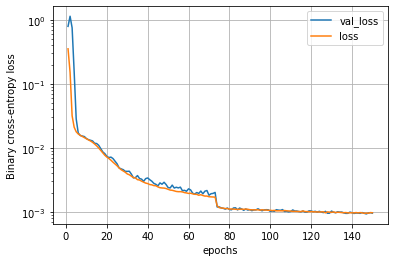

SNR: 1 bit error rate =  0.2323131
SNR: 2 bit error rate =  0.2049622
SNR: 3 bit error rate =  0.1787162
SNR: 4 bit error rate =  0.1541049
SNR: 5 bit error rate =  0.1305714
SNR: 6 bit error rate =  0.1077888
SNR: 7 bit error rate =  0.0855597
SNR: 8 bit error rate =  0.064744
SNR: 9 bit error rate =  0.0454496
SNR: 10 bit error rate =  0.0292158
SNR: 11 bit error rate =  0.0168048
SNR: 12 bit error rate =  0.0083844
SNR: 13 bit error rate =  0.0035181
SNR: 14 bit error rate =  0.0011986
SNR: 15 bit error rate =  0.0003149
SNR: 16 bit error rate =  7.19e-05
SNR: 17 bit error rate =  1.05e-05
SNR: 18 bit error rate =  1.7e-06
SNR: 19 bit error rate =  1e-07
SNR: 20 bit error rate =  0.0
SNR: 21 bit error rate =  0.0
SNR: 22 bit error rate =  0.0
SNR: 23 bit error rate =  0.0
SNR: 24 bit error rate =  0.0
[0.2323131, 0.2049622, 0.1787162, 0.1541049, 0.1305714, 0.1077888, 0.0855597, 0.064744, 0.0454496, 0.0292158, 0.0168048, 0.0083844, 0.0035181, 0.0011986, 0.0003149, 7.19e-05, 1.05e-05,

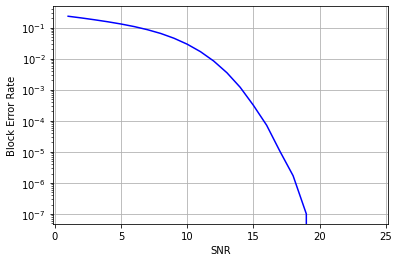

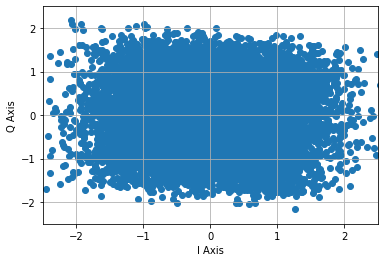

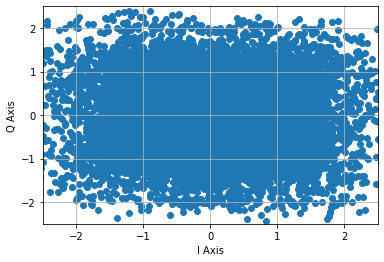

In [ ]:
% tensorflow_version 1.x

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Lambda, BatchNormalization, Input, Conv1D, TimeDistributed, Flatten, Activation, ZeroPadding1D
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, History, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as KR
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import GRU, LSTM, Bidirectional, Reshape
import tensorflow as tf

'''
 --- COMMUNICATION PARAMETERS ---
'''

# Bits per Symbol
k = 4
power = 0.3482**2 + 0.8704**2 + 0.3482**2

# Number of symbols
L = 100

# Channel Use
n = 1

# Effective Throughput
#  bits per symbol / channel use
R = k / n

# Eb/N0 used for training
train_Eb_dB = 15

# Noise Standard Deviation
noise_sigma = np.sqrt(power / (2 * R * 10 ** (train_Eb_dB / 10)))


# Number of messages used for training, each size = k*L
batch_size = 1000

train_num = batch_size*150



early_stopping_patience = 100

epochs = 150

optimizer = Adam(lr=0.001)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=early_stopping_patience)


# Learning Rate Control
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0001)

# Save the best results based on Training Set
modelcheckpoint = ModelCheckpoint(filepath='./' + 'model_LBC_' + str(k) + '_' + str(L) + '_' + str(n) + '_' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN' + '.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)


train_label = np.random.randint(0,2, size = (train_num,k*L))
train_data = np.reshape(train_label, newshape=(train_num, L, k))  # input


# Define Power Norm for Tx
def normalization(x):
    mean = KR.mean(x ** 2)
    return x / KR.sqrt(2 * mean)  # 2 = I and Q channels


# Define Channel Layers including AWGN and Flat Rayleigh fading
#  x: input data
#  sigma: noise std
def channel_layer(x, sigma):

    w = KR.random_normal(KR.shape(x), mean=0.0, stddev=sigma)

    return x + w

def ISI_layer(x):
    taps = 3
    h = np.array([0.3482, 0.8704, 0.3482]) # weights
    dim = x.shape[1] 
    split = Lambda(lambda x:tf.split(x,num_or_size_splits=2,axis=2))(x)
    ISI_1_0 = split[0]
    ISI_2_0 = split[1]

    # print(ISI_1_0.shape)
    ISI_1_1 = ZeroPadding1D(1)(ISI_1_0)
    ISI_1_1 = Lambda(lambda x: x[:,0:L])(ISI_1_1)
    ISI_1_2 = ZeroPadding1D(1)(ISI_1_1)
    ISI_1_2 = Lambda(lambda x: x[:,0:L])(ISI_1_2)

    ISI_2_1 = ZeroPadding1D(1)(ISI_2_0)
    ISI_2_1 = Lambda(lambda x: x[:,0:L])(ISI_2_1)
    ISI_2_2 = ZeroPadding1D(1)(ISI_2_1)
    ISI_2_2 = Lambda(lambda x: x[:,0:L])(ISI_2_2)

    ISI1 = h[0]*ISI_1_0+h[1]*ISI_1_1+h[2]*ISI_1_2
    ISI2 = h[0]*ISI_2_0+h[1]*ISI_2_1+h[2]*ISI_2_2

    ISI_x =  KR.concatenate((ISI1, ISI2), axis=-1)   
    # print(ISI_x.shape) 
    return ISI_x    

model_input = Input(batch_shape=(None, L, k), name='input_bits')

e = Conv1D(filters=256, strides=1, kernel_size=7, name='e_1',padding='same')(model_input)
e = BatchNormalization(name='e_2')(e)
e = Activation('relu', name='e_3')(e)

e = Conv1D(filters=256, strides=1, kernel_size=7, name='e_4',padding='same')(e)
e = BatchNormalization(name='e_5')(e)
e = Activation('relu', name='e_6')(e)

e = Conv1D(filters=2, strides=1, kernel_size=7, name='e_7',padding='same')(e)
e = BatchNormalization(name='e_8')(e)
e = Activation('linear', name='e_9')(e)




e_noISI = Lambda(normalization, name='power_norm')(e)

#ISI#
e_ISI = Lambda(ISI_layer, name='ISI')(e_noISI)

y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma}, name='channel_layer')(e_ISI)


d = Conv1D(filters=256, strides=1, kernel_size=7, name='d_1',padding='same')(y_h)
d = BatchNormalization(name='d_2')(d)
d = Activation('relu', name='d_3')(d)

d = Conv1D(filters=256, strides=1, kernel_size=7, name='d_4',padding='same')(d)
d = BatchNormalization(name='d_5')(d)
d = Activation('relu', name='d_6')(d)

model_output = Conv1D(filters=k, strides=1, kernel_size=7, name='d_10', activation='sigmoid',padding='same')(d)



sys_model = Model(model_input, model_output)
encoder = Model(model_input, e_ISI)
sys_model.summary()
sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

decode_input = Input(batch_shape=(None, L, 2*n))
dec = sys_model.layers[-7](decode_input)
dec = sys_model.layers[-6](dec)
dec = sys_model.layers[-5](dec)
dec = sys_model.layers[-4](dec)
dec = sys_model.layers[-3](dec)
dec = sys_model.layers[-2](dec)
dec = sys_model.layers[-1](dec)
decoder = Model(decode_input, dec)
decoder.summary()
print('starting train the NN...')
start = time.clock()

# TRAINING
mod_history = sys_model.fit(train_data, train_data,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.1, callbacks=[modelcheckpoint,reduce_lr])

end = time.clock()

print('The NN has trained ' + str(end - start) + ' s')


# Plot the Training Loss and Validation Loss
hist_dict = mod_history.history

val_loss = hist_dict['val_loss']
loss = hist_dict['loss']
#acc = hist_dict['acc']
# val_acc = hist_dict['val_acc']
print('loss:',loss)
print('val_loss:',val_loss)

epoch = np.arange(1, epochs + 1)

plt.semilogy(epoch,val_loss,label='val_loss')
plt.semilogy(epoch, loss, label='loss')

plt.legend(loc=0)
plt.grid('true') 
plt.xlabel('epochs')
plt.ylabel('Binary cross-entropy loss')

plt.show()

#sys_model.save('/content/drive/My Drive/cnn_AE12_model.h5')
#encoder.save('/content/drive/My Drive/cnn_AE12_enc.h5')

##
def AWGN(x, SNR):  
  EbNo=10.0**(SNR/10.0)
  noise_std = np.sqrt(power/(2*R*EbNo))
  n = np.random.normal(0,noise_std,np.shape(x))
  noisy_signal = n + x
  return noisy_signal

test_num = 25000
test_label = np.random.randint(0,2, size = (test_num,k*L))
test_data = np.reshape(test_label, newshape=(test_num, L, k))  # input 

NN = np.shape(test_label)[0]* np.shape(test_label)[1]

err = []
EbNo_dB = []

for SNR in range(1, 25, 1):
  
  test_encoded = encoder.predict(test_data)

  # AWGN
  test_noisy = AWGN(test_encoded, SNR)

  # decoder 
  predict = decoder.predict(test_noisy)
 
  # binary form 
  '''
  binary_predict = []

  for item in predict: 
    binary_predict.append([1 if i>=0.5 else 0 for i in item])
  '''
  predict[(predict >= 0.5)] = 1
  predict[(predict < 0.5)] = 0

  num_error = (test_data != predict).astype(int).sum()

  error_rate = num_error/NN
  err.append(error_rate)
  EbNo_dB.append(SNR)
  print('SNR:', SNR, 'bit error rate = ', error_rate)


print(err)
import matplotlib.pyplot as plt
plt.plot(EbNo_dB, err, 'b')
plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Block Error Rate')
plt.grid() 


import statistics
import matplotlib.pyplot as plt
test_num = 2000
test_label = np.random.randint(0,2, size = (test_num,k*L))
test_data = np.reshape(test_label, newshape=(test_num, L, k))  # input

encoder = Model(model_input, e_ISI)
encoded_signal = encoder.predict(test_data) 
a = encoded_signal.reshape(test_num*L*n,2)


f = plt.figure()
scatter_plot = a.reshape(test_num*L*n,2)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

f.savefig("Constellations After ISI.jpg")


test_num = 2000
test_label = np.random.randint(0,2, size = (test_num,k*L))
test_data = np.reshape(test_label, newshape=(test_num, L, k))  # input

encoder = Model(model_input, e_noISI)
encoded_signal = encoder.predict(test_data) 
a = encoded_signal.reshape(test_num*L*n,2)


f = plt.figure()
scatter_plot = a.reshape(test_num*L*n,2)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

f.savefig("Constellations Before ISI.jpg")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
sys_model.save('/content/drive/My Drive/cnn_AE13_model.h5')
encoder.save('/content/drive/My Drive/cnn_AE13_enc.h5')